## Using the Cityscape Dataset downloaded from Kaggle to train a Segmentation Model

In [2]:
# Fist connect google drive with colab
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
import numpy as np 
import pandas as pd
import os
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tensorflow.keras.layers import Conv2D,MaxPool2D,Dropout,UpSampling2D,Concatenate,Input,Softmax
from tensorflow.keras import Model
from tensorflow.keras.callbacks import ModelCheckpoint

Set Parameters

In [4]:
EPOCHS=10
BATCH_SIZE=10
HEIGHT=256
WIDTH=256
N_CLASSES=13

In [5]:
def load_image(dpath, fname):
  '''
  function to split the kaggle images to the 
  input image and the corresponding mask

  Args:
    dpath: the path where the images are
    fname: the name of the image

  Return:
    im: the input image
    mask: the corresponding output
  '''

  image = Image.open(os.path.join(dpath, fname))
  image = np.array(image)
  size = image.shape
  im = image[:,:size[1]//2]
  mask = image[:,size[1]//2:]
  return im, mask

def bin_mask(mask):
  '''
  #############################
  Funktion genauer angucken
  #############################
  '''
  bins = np.array([20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240])
  new_mask = np.digitize(mask, bins)
  return new_mask

def getSegmentationArr(image, classes, width= WIDTH, height= HEIGHT):
  '''
  Create a Mask for every class. Creating an array or Dim (height, width, classes)
  Every channel will contain only one class

  Args:
    image:
    classes:
    width:
    height:

  Returns:
    seg_labels: Numpy array, with "classes" channel, where every channel contain only 1 or 0
  '''

  seg_labels = np.zeros((height, width, classes)) # Create a Numpy label corresponding to the mask/image size
  img = image[:,:,0] # get one channel of the image

  for c in range(classes):
    seg_labels[:, :, c] = (img == c).astype(int) # Iterate over all classes. if the image contains the class, it will be saved in a seperate CLASS CHANNEL
  
  return seg_labels

def give_color_to_seg_img(seg, n_classes=N_CLASSES):
    
    seg_img = np.zeros( (seg.shape[0],seg.shape[1],3) ).astype('float')
    print(seg_img.shape)
    colors = sns.color_palette("hls", n_classes)
    
    for c in range(n_classes):
        segc = (seg == c)
        seg_img[:,:,0] += (segc*( colors[c][0] ))
        seg_img[:,:,1] += (segc*( colors[c][1] ))
        seg_img[:,:,2] += (segc*( colors[c][2] ))

    return seg_img


In [6]:
image, mask = load_image("/content/gdrive/MyDrive/Dataset/cityscapes_data/cityscapes_data/train/","1.jpg")
print(image.shape, mask.shape)

test = getSegmentationArr(mask, classes=13)
print(test.shape)

(256, 256, 3) (256, 256, 3)
(256, 256, 13)


## Dataset

In [7]:
train_folder = "/content/gdrive/MyDrive/Dataset/cityscapes_data/train"
valid_folder = "/content/gdrive/MyDrive/Dataset/cityscapes_data/val"

num_of_training_samples = len(os.listdir(train_folder))
num_of_valid_samples = len(os.listdir(valid_folder))

print(f"Num of Training samples: {num_of_training_samples}")
print(f"Num of Validation samples: {num_of_valid_samples}")

def DataGenerator(path, batch_size=BATCH_SIZE, classes=N_CLASSES):
  '''
  '''

  files = os.listdir(path)
  while True:
    for i in range(0, len(files), batch_size):   # from 0 - len(files) using batch size as steps
      batch_files = files[i : i + batch_size] # Fill the batch files with "batch_size" images
      imgs = list()
      segs = list()
      for file in batch_files:
        image, mask = load_image(path, file)
        mask_binned = bin_mask(mask)
        labels = getSegmentationArr(mask_binned, classes)

        imgs.append(image)
        segs.append(labels)
      yield np.array(imgs), np.array(segs) # With yield you return Generators, which can be iterated over ONCE and don't need all the space, because data is used "on the fly"
                                          
      

Num of Training samples: 2975
Num of Validation samples: 500


In [8]:
train_gen = DataGenerator(train_folder, batch_size=BATCH_SIZE)
val_gen = DataGenerator(valid_folder, batch_size=BATCH_SIZE)
print(train_gen)

<generator object DataGenerator at 0x7fc0c5f8d950>


In [9]:
### Check if the batches are given the way we want it
imgs, segs = next(train_gen)

print(f"Shape of Training Batch: Image: {imgs.shape}, Label: {segs.shape}")

Shape of Training Batch: Image: (10, 256, 256, 3), Label: (10, 256, 256, 13)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)
(256, 256, 3)


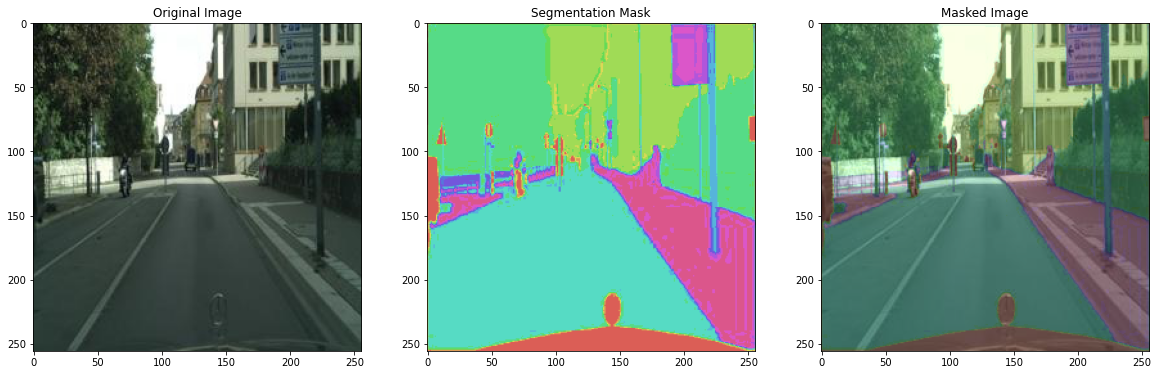

In [10]:
image = imgs[5]
mask = give_color_to_seg_img(np.argmax(segs[5], axis=-1))
print(mask.shape)
masked_image = cv2.addWeighted(image/255, 0.8, mask, 0.3, 0)

fig, axs = plt.subplots(1, 3, figsize=(20,20))
axs[0].imshow(image)
axs[0].set_title('Original Image')
axs[1].imshow(mask)
axs[1].set_title('Segmentation Mask')
#predimg = cv2.addWeighted(imgs[i]/255, 0.6, _p, 0.4, 0)
axs[2].imshow(masked_image)
axs[2].set_title('Masked Image')
plt.show()

## Define a Model

Shape after two Convs: (10, 256, 256, 3), Shape after Maxpool: (10, 128, 128, 128)
Shape after UpBlock: (10, 256, 256, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_578 (Conv2D)             (None, 256, 256, 16) 448         input_12[0][0]                   
__________________________________________________________________________________________________
conv2d_579 (Conv2D)             (None, 256, 256, 16) 2320        conv2d_578[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_129 (MaxPooling2D (None, 128, 128, 16) 0           conv2d_579[0][0]                 
____________________________________________________________________________________________

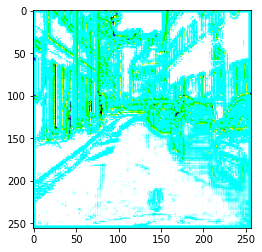

In [44]:
'''

class DownBlock(Model):
  def __init__(self, filters, kernel_size=(3, 3), padding='same', strides=1):
    super().__init__()
    self.filters = filters
    self.kernel_size = kernel_size
    self.padding = padding
    self.strides = strides
    self.conv1 = Conv2D(self.filters, self.kernel_size, padding=self.padding, strides=self.strides)
    self.conv2 = Conv2D(self.filters, self.kernel_size, padding=self.padding, strides=self.strides)
    self.pool = MaxPool2D((2, 2), (2, 2))

  def call(self, x):
    c = self.conv1(x)
    c = self.conv2(c)
    p = self.pool(c)

    return x, p  #Return the downsampled image and the original resolution for the skip connections

class UpBlock(Model):
  def __init__(self, filters, kernel_size=(3, 3), padding='same', strides=1, activation='relu'):
    super().__init__()
    self.filters = filters
    self.kernel_size = kernel_size 
    self.padding = padding 
    self.strides = strides
    self.activation = activation
    self.up = UpSampling2D((2, 2))
    self.concat = Concatenate()
    self.conv1 = Conv2D(self.filters, self.kernel_size, padding=self.padding, strides=self.strides, activation=self.activation)
    self.conv2 = Conv2D(self.filters, self.kernel_size, padding=self.padding, strides=self.strides, activation=self.activation)

  def call(self, x, skip):
    us = self.up(x)
    concat = self.concat([us, skip])
    c = self.conv1(concat)
    c = self.conv2(concat)
    return c

class BottleNeck(Model):
  def __init__(self, filters, kernel_size=(3, 3), padding='same', strides=1):
    super().__init__()
    self.filters = filters
    self.kernel_size = kernel_size 
    self.padding = padding 
    self.strides = strides
    self.conv1 = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")
    self.conv2 = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")

  def call(self, x):
    c = conv1(x)
    c = conv2(c)
    return c

class UNet(Model):
  def __init__(self, filters: list):
    super().__init__()

    self.filters = filters

    self.down1 = DownBlock(filters[0], kernel_size=(3, 3), padding='same', strides=1)
    self.down2 = DownBlock(filters[1], kernel_size=(3, 3), padding='same', strides=1)
    self.down3 = DownBlock(filters[2], kernel_size=(3, 3), padding='same', strides=1)
    self.down4 = DownBlock(filters[3], kernel_size=(3, 3), padding='same', strides=1)

    self.bottleneck = BottleNeck(filters[4])

    self.up1 = UpBlock(filters[3], kernel_size=(3, 3), padding='same', strides=1, activation='relu')
    self.up2 = UpBlock(filters[2], kernel_size=(3, 3), padding='same', strides=1, activation='relu')
    self.up3 = UpBlock(filters[1], kernel_size=(3, 3), padding='same', strides=1, activation='relu')
    self.up4 = UpBlock(filters[0], kernel_size=(3, 3), padding='same', strides=1, activation='relu')

    self.out = Conv2D(13, (1, 1), padding="same", activation="sigmoid")


  def call(self, x):

    p0 = x
    c1, p1 = self.down1(p0, self.filters[0])
    c2, p2 = self.down2(p1, self.filters[1])
    c3, p3 = self.down1(p2, self.filters[2])
    c4, p4 = self.down2(p3, self.filters[3])

    bn = self.bottleneck(p4, f[4])

    u1 = self.up1(bn, c4, f[3])
    u2 = self.up1(u1, c3, f[2])
    u3 = self.up1(u2, c2, f[1])
    u4 = self.up1(u3, c1, f[0])

    outputs = self.out(u4)

    return outputs

'''
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = UpSampling2D((2, 2))(x)
    concat = Concatenate()([us, skip])
    c = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def UNet():
    f = [16, 32, 64, 128, 256]
    inputs = Input((HEIGHT,WIDTH,3))
    
    p0 = inputs
    c1, p1 = down_block(p0, f[0]) #128 -> 64
    c2, p2 = down_block(p1, f[1]) #64 -> 32
    c3, p3 = down_block(p2, f[2]) #32 -> 16
    c4, p4 = down_block(p3, f[3]) #16->8
    
    bn = bottleneck(p4, f[4])
    
    u1 = up_block(bn, c4, f[3]) #8 -> 16
    u2 = up_block(u1, c3, f[2]) #16 -> 32
    u3 = up_block(u2, c2, f[1]) #32 -> 64
    u4 = up_block(u3, c1, f[0]) #64 -> 128

    outputs = Conv2D(13, (1, 1), padding="same", activation="sigmoid")(u4)
    model = Model(inputs, outputs)
    return model



### Test Downblock
down = DownBlock(128)
ori, down = down(imgs.astype('float32'))
print(f"Shape after two Convs: {ori.shape}, Shape after Maxpool: {down.shape}")

### Test UpBlock

up = UpBlock(3)
test = up(down, ori)
print(f"Shape after UpBlock: {test.shape}")

plt.imshow(test[1])


### Test UNet
f = [16, 32, 64, 128, 256]
unet = UNet()
unet.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["acc"])
unet.summary()


In [45]:
checkpoint = ModelCheckpoint('seg_model.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')

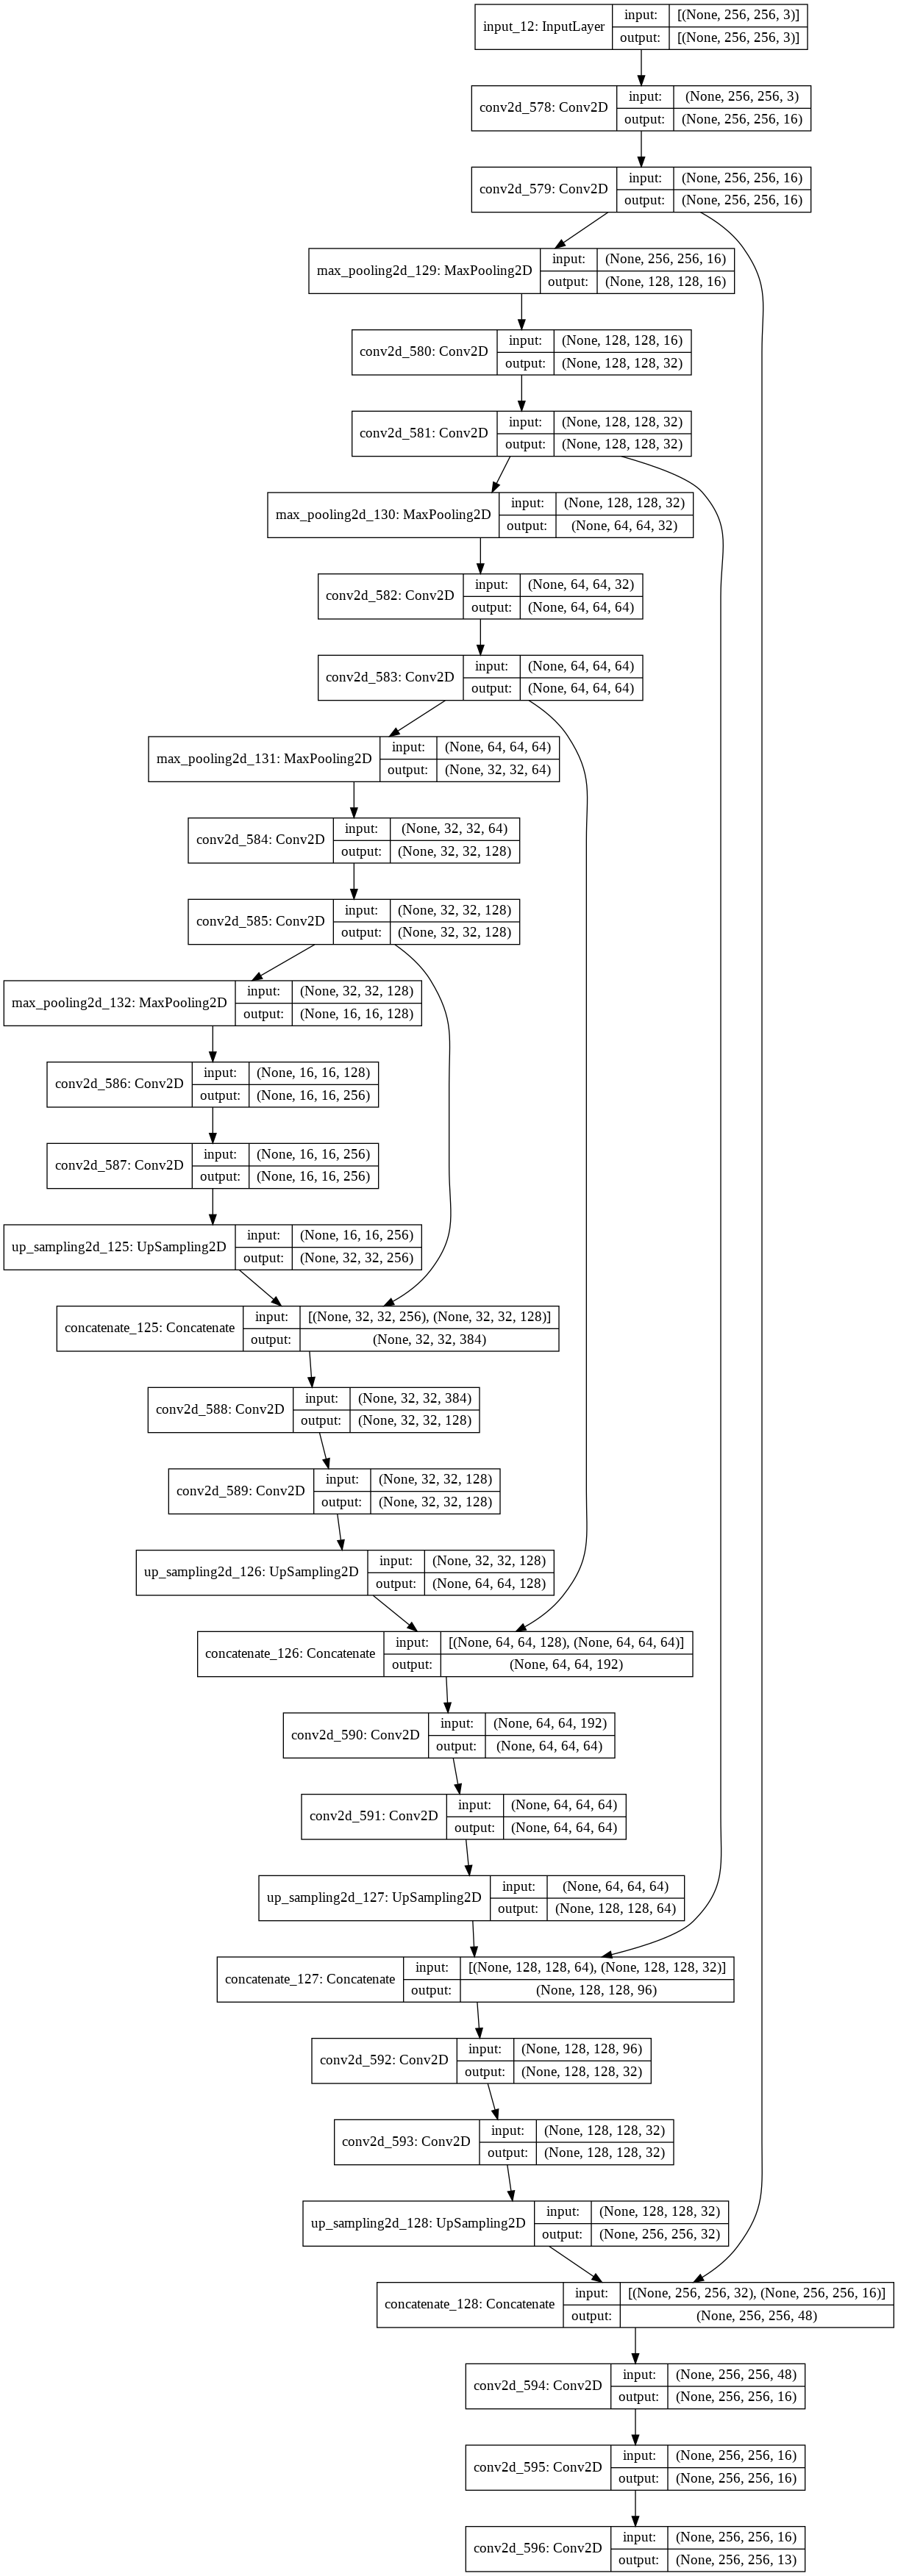

In [46]:
tf.keras.utils.plot_model(unet,show_shapes=True )

In [48]:
TRAIN_STEPS = num_of_training_samples//BATCH_SIZE+1
VAL_STEPS = num_of_valid_samples//BATCH_SIZE+1

unet.fit_generator(train_gen, validation_data=val_gen, steps_per_epoch=TRAIN_STEPS, 
                    validation_steps=VAL_STEPS, epochs=EPOCHS, callbacks = checkpoint)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
298/298 [==============================] - 2186s 7s/step - loss: 1.5632 - acc: 0.5752 - val_loss: 1.2505 - val_acc: 0.6450

Epoch 00001: val_acc improved from -inf to 0.64496, saving model to seg_model.hdf5
Epoch 2/10
298/298 [==============================] - 89s 299ms/step - loss: 1.1106 - acc: 0.6813 - val_loss: 1.1191 - val_acc: 0.6874

Epoch 00002: val_acc improved from 0.64496 to 0.68735, saving model to seg_model.hdf5
Epoch 3/10
298/298 [==============================] - 89s 299ms/step - loss: 0.9963 - acc: 0.7184 - val_loss: 1.0249 - val_acc: 0.7163

Epoch 00003: val_acc improved from 0.68735 to 0.71627, saving model to seg_model.hdf5
Epoch 4/10
298/298 [==============================] - 89s 299ms/step - loss: 0.9108 - acc: 0.7451 - val_loss: 0.9600 - val_acc: 0.7359

Epoch 00004: val_acc improved from 0.71627 to 0.73593, saving model to seg_model.hdf5
Epoch 5/10
298/298 [==============================] - 89s 299ms/step - loss: 0.8612 - acc: 0.7588 - val_loss: 0.9678

(256, 256, 3)
(256, 256, 3)


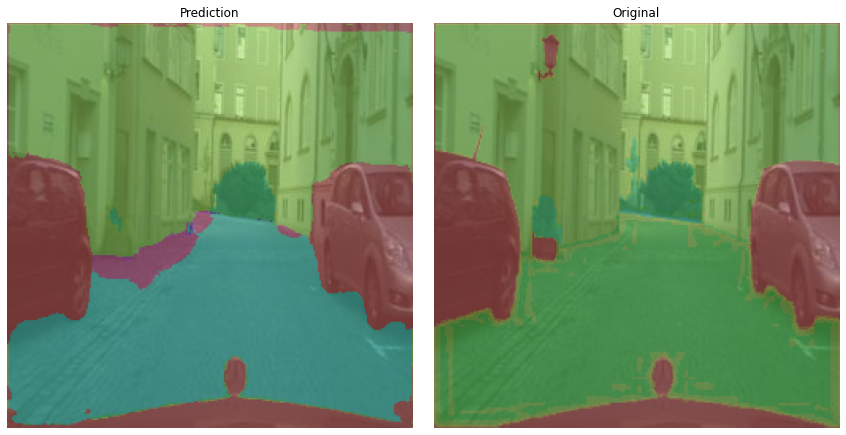

In [51]:
max_show = 1
imgs, segs = next(val_gen)
pred = unet.predict(imgs)

for i in range(max_show):
    _p = give_color_to_seg_img(np.argmax(pred[i], axis=-1))
    _s = give_color_to_seg_img(np.argmax(segs[i], axis=-1))

    predimg = cv2.addWeighted(imgs[i]/255, 0.5, _p, 0.5, 0)
    trueimg = cv2.addWeighted(imgs[i]/255, 0.5, _s, 0.5, 0)
    
    plt.figure(figsize=(12,6))
    plt.subplot(121)
    plt.title("Prediction")
    plt.imshow(predimg)
    plt.axis("off")
    plt.subplot(122)
    plt.title("Original")
    plt.imshow(trueimg)
    plt.axis("off")
    plt.tight_layout()
    plt.savefig("pred_"+str(i)+".png", dpi=150)
    plt.show()